# Issue:  
I concern that some dinks have much large stellar mass or cold gas mass.  
Let's find their child.  

Also, I found some system have more halo(or galaxy).  
For example, See ID=10. at the top, there is one massive galaxy coming in.

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy


In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

LG = pklload("./database/00_LocalGroup_fix.pickle")
print(LG.keys())
print(LG[2].keys())

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])


In [3]:
MASSs = pklload("./database/01_mass_in_sub.pickle")
MASSs_rvir = pklload("./database/01_mass_in_sub.pickle")

In [5]:
MASSs.dtype

dtype((numpy.record, [('host', '<i4'), ('sub', '<i4'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8')]))

In [7]:
np.min(gals['m'])

859259.6477831252

In [8]:
8e5

800000.0

In [29]:
def point_in_sphere(point, sphere, rname='r', factor=1):
    dist = np.sqrt( (point['x'] - sphere['x'])**2 + (point['y'] - sphere['y'])**2 + (point['z'] - sphere['z'])**2 )
    # print(dist, sphere[rname]*factor)
    return dist < sphere[rname]*factor

def sphere_in_sphere(inner, outer, r1='r',r2='r', factor=1):
    dist = np.sqrt( (inner['x'] - outer['x'])**2 + (inner['y'] - outer['y'])**2 + (inner['z'] - outer['z'])**2 )
    # print(dist+inner[r1], outer[r2])
    return (dist+inner[r1]) < outer[r2]

def sphere_touch_sphere(sph1, sph2, r1='r',r2='r', factor=1):
    dist = np.sqrt( (sph1['x'] - sph2['x'])**2 + (sph1['y'] - sph2['y'])**2 + (sph1['z'] - sph2['z'])**2 )
    # print(dist, sph1[r1]+sph2[r2])
    return dist < (sph1[r1]+sph2[r2])*factor


[1] 2/96 are matched


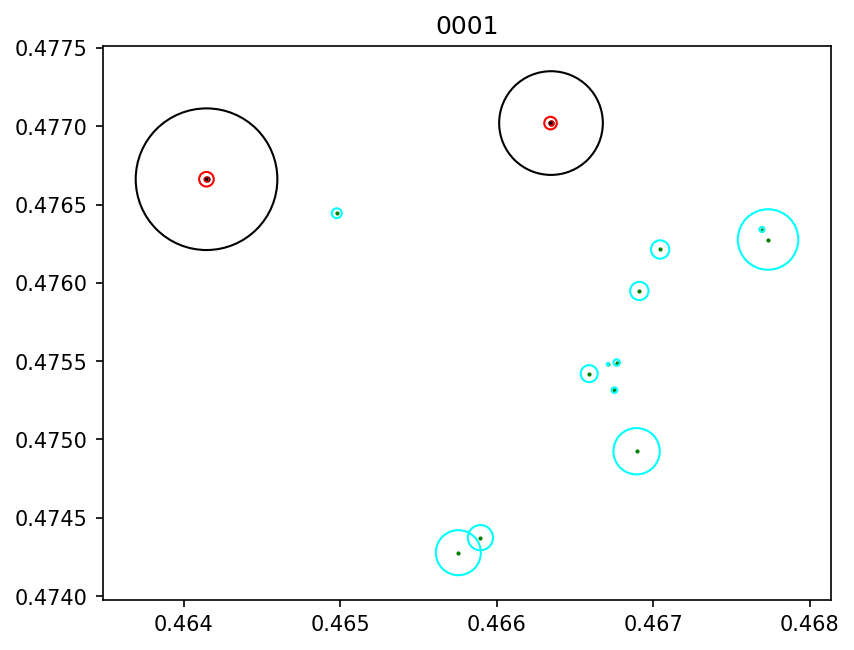

[2] 5/477 are matched


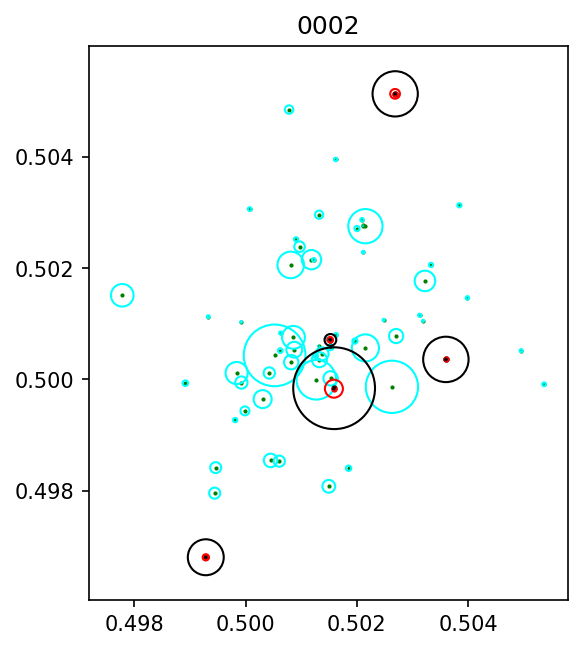

[3] 3/50 are matched


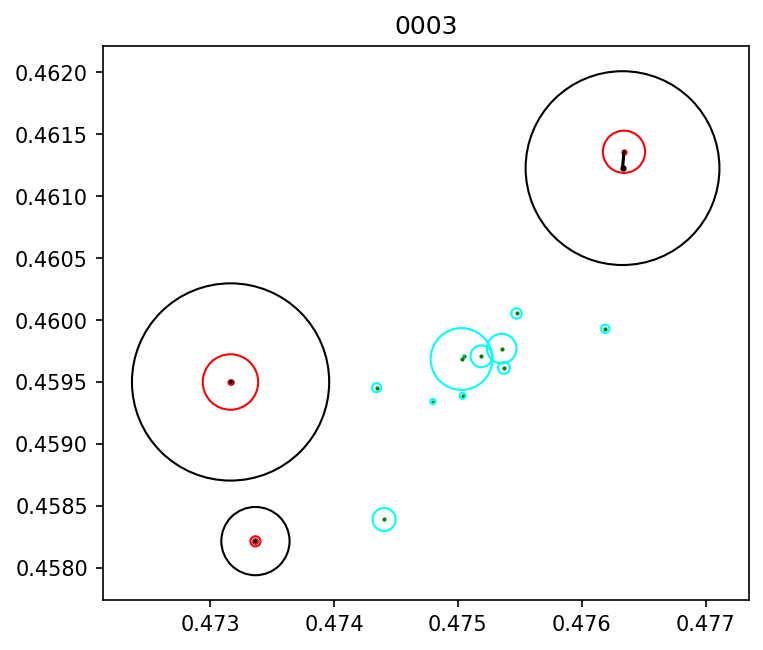

[4] 7/417 are matched


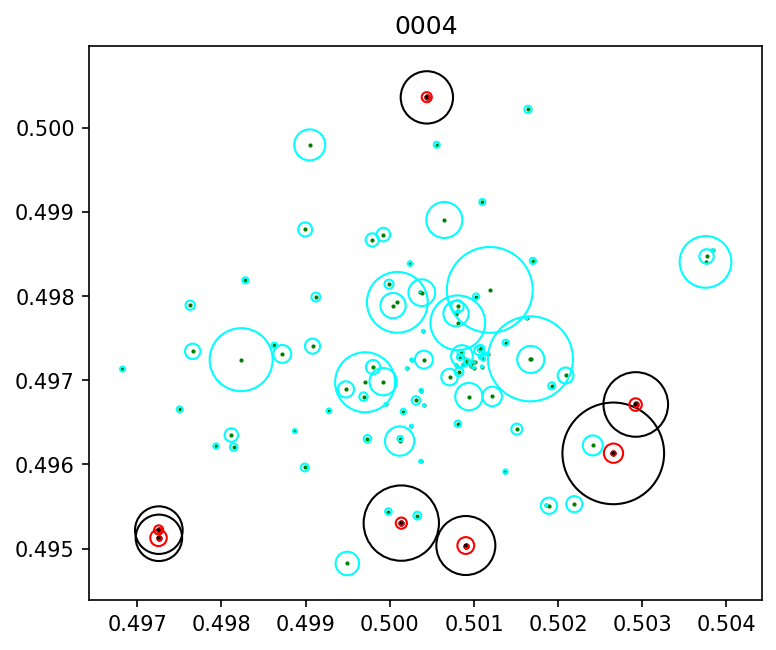

[7] 2/77 are matched


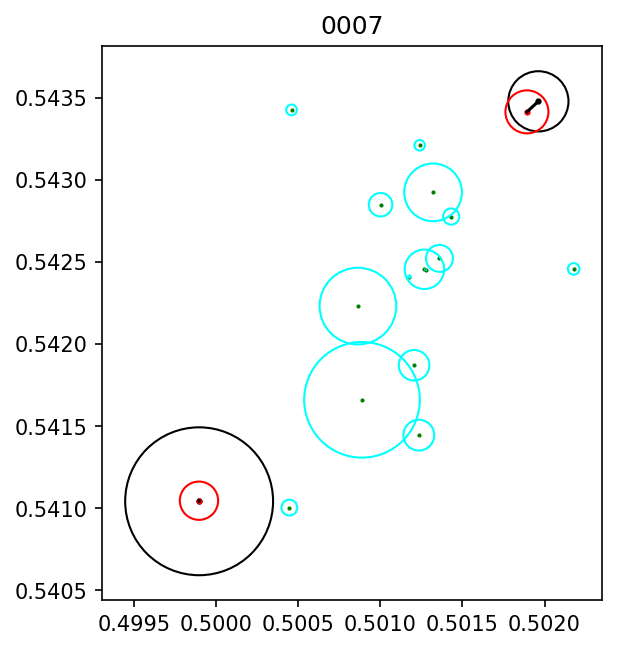

[8] 2/80 are matched


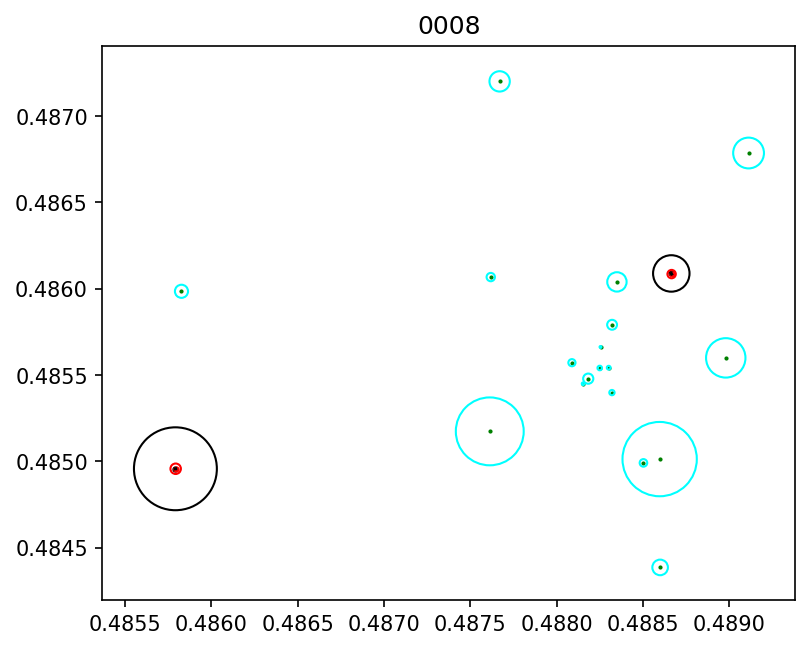

[9] 2/103 are matched


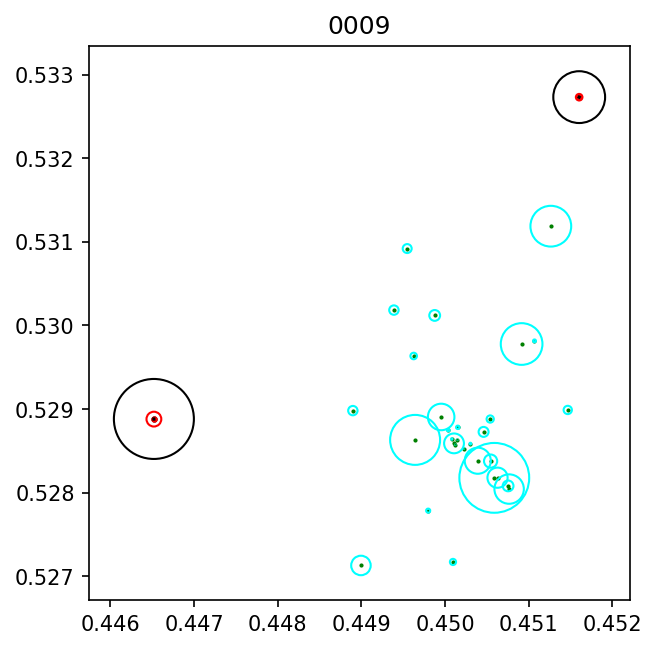

[10] 1/77 are matched


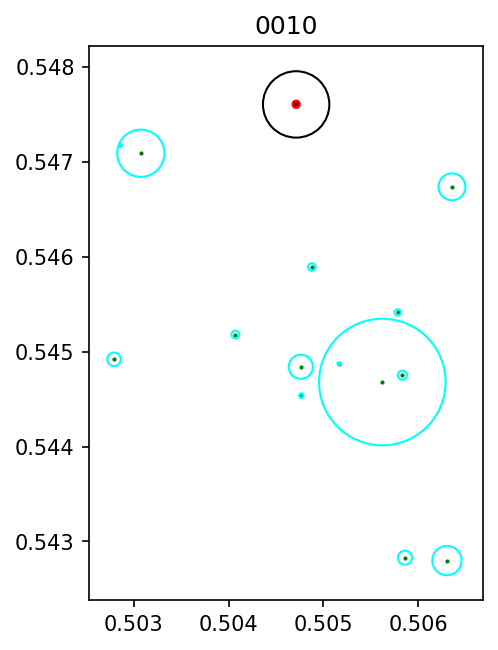

[14] 4/350 are matched


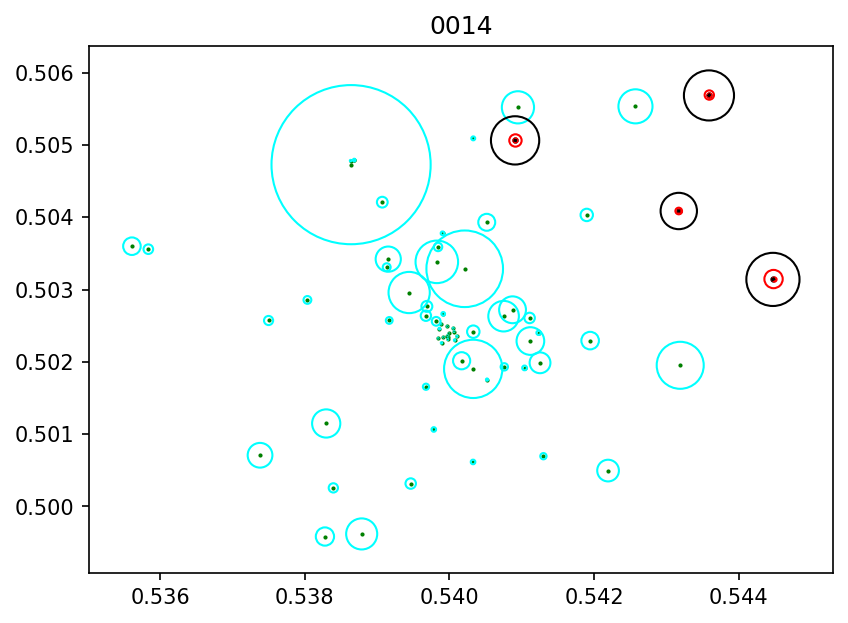

[17] 1/24 are matched


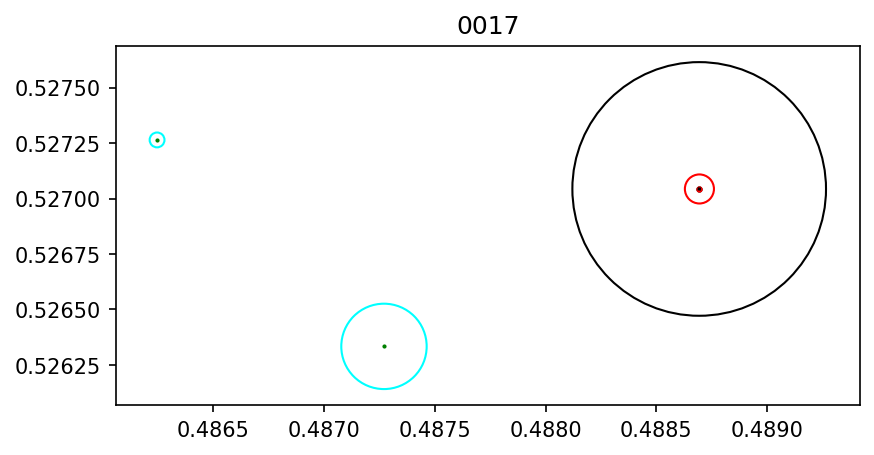

[24] 1/22 are matched


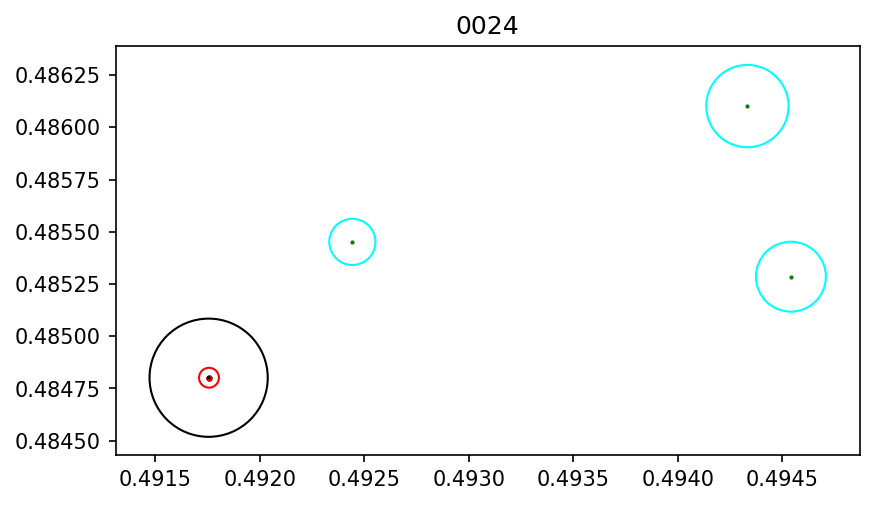

[25] 4/157 are matched


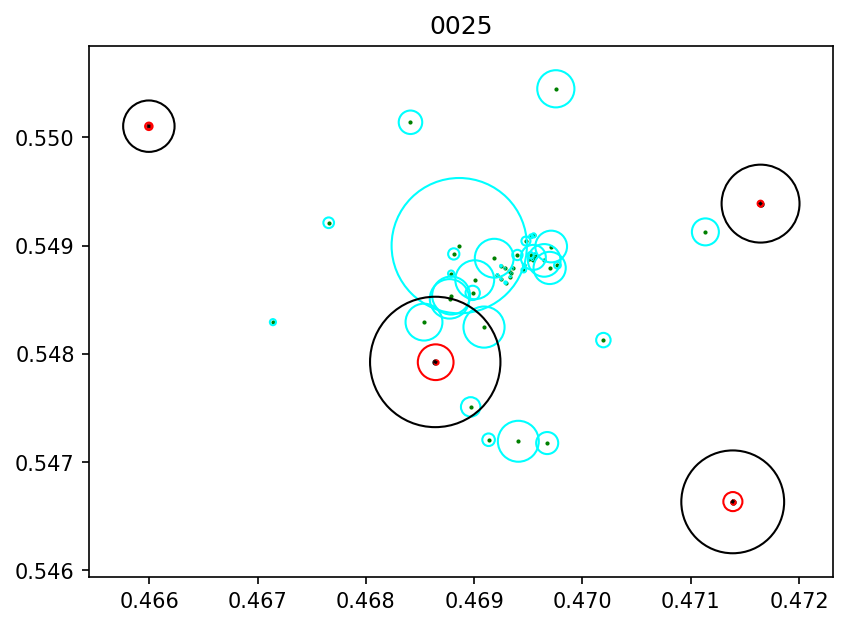

[29] 1/28 are matched


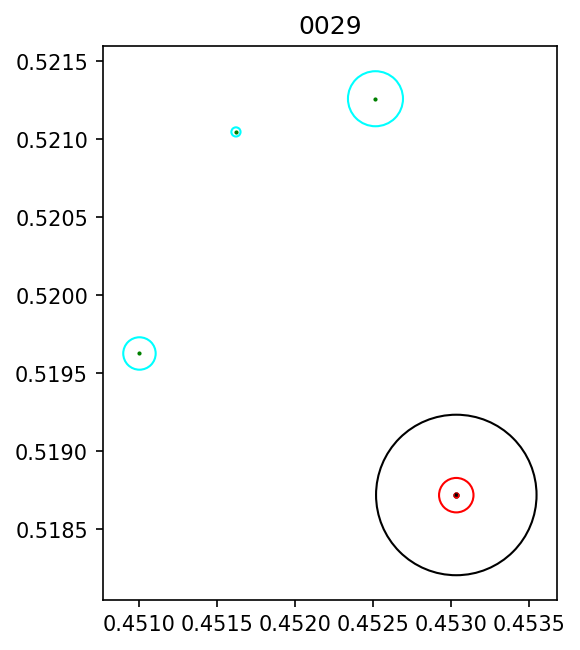

[36] 3/159 are matched


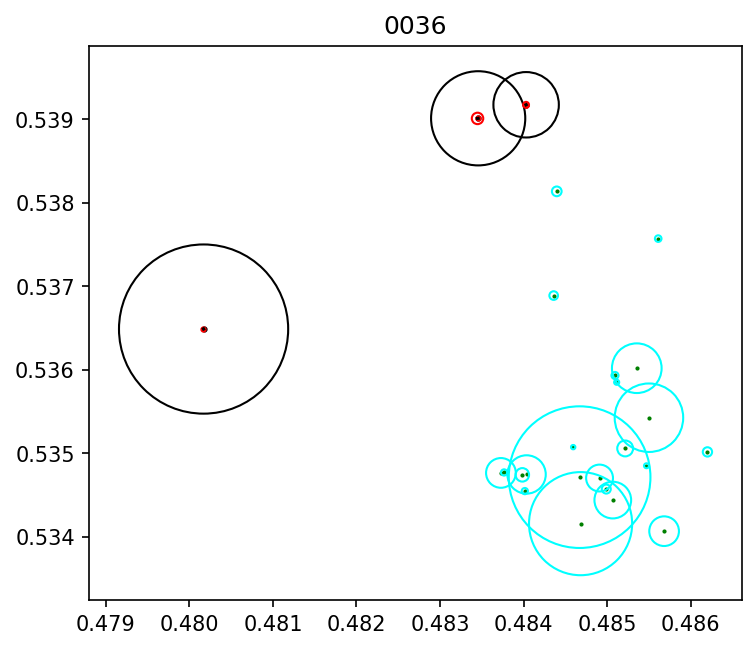

[40] 1/5 are matched


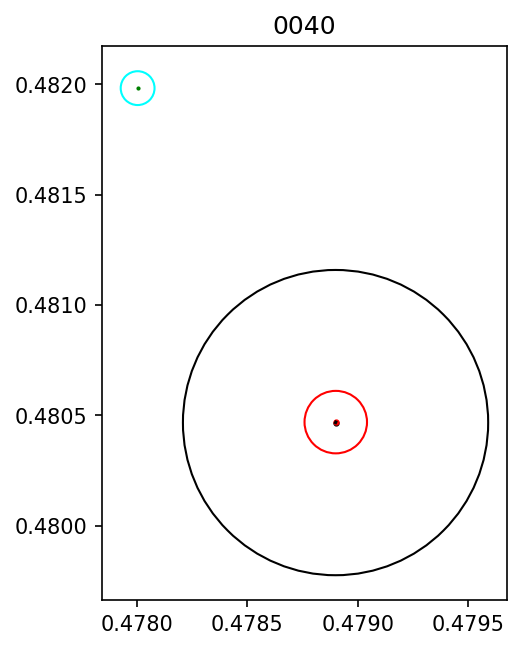

[46] 2/72 are matched


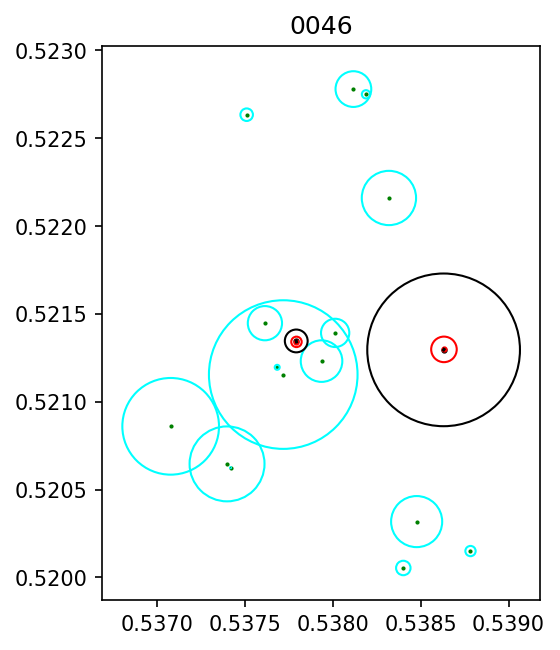

[75] 3/12 are matched


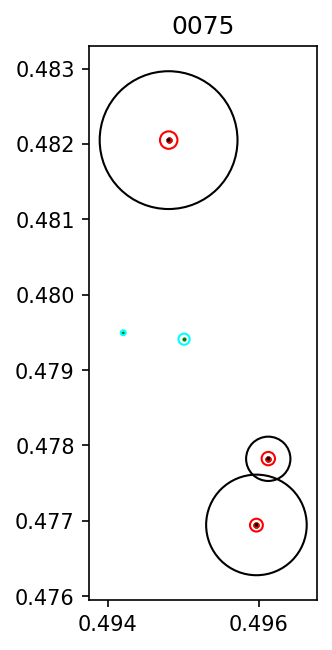

[84] 1/18 are matched


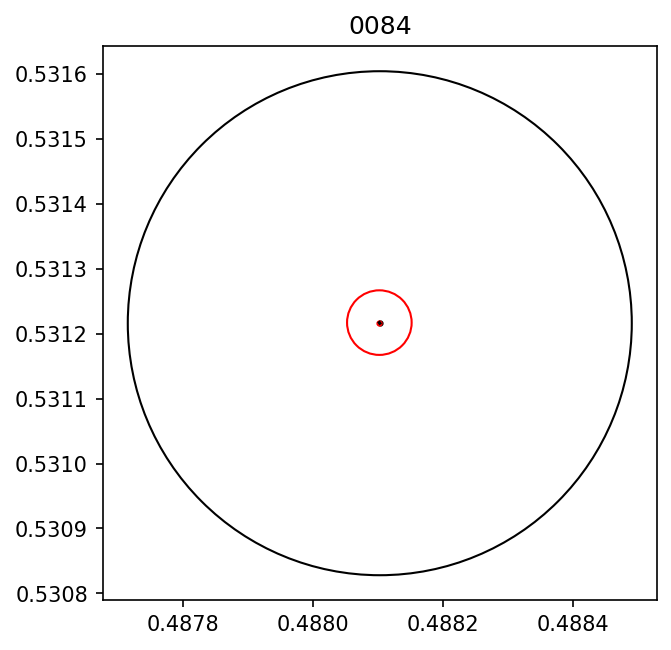

[92] 1/31 are matched


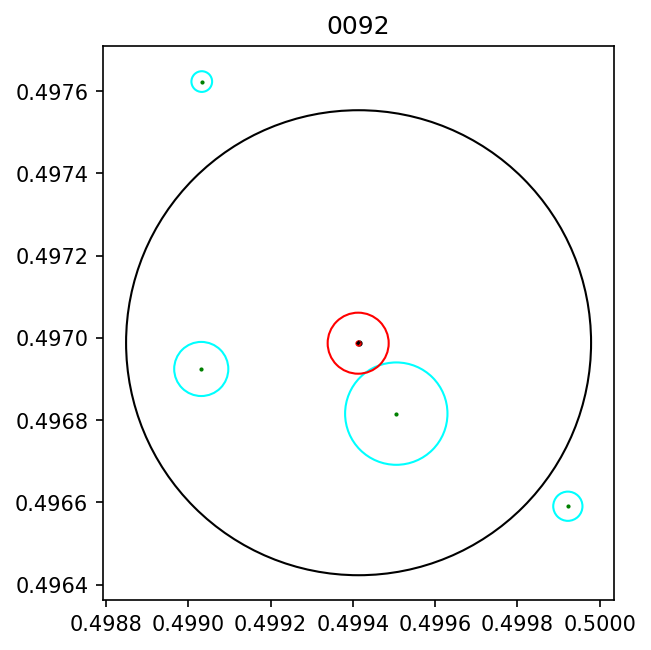

[107] 1/21 are matched


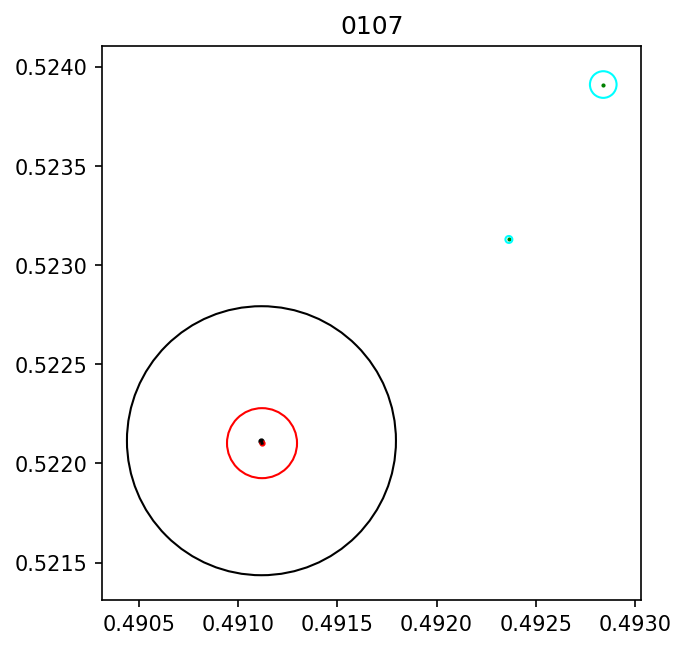

[129] 1/25 are matched


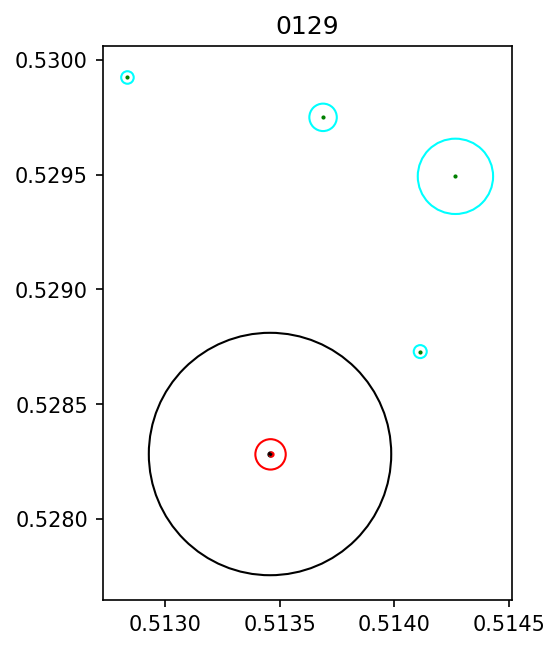

In [30]:
for key in LG.keys():
    BGG = LG[key]['BGG']
    sats = LG[key]['sats']
    subs = LG[key]['subs']
    real = LG[key]['real']
    igals = gals[~isin(gals['id'], subs['id'])]
    igals = igals[igals['id'] != BGG['id']]
    LG[key]['parking'] = None

    tmp = MASSs[MASSs['host']==key]
    tmp = tmp[tmp['dink']]
    fig, ax = plt.subplots(dpi=150)
    ax.scatter(sats['x'], sats['y'], color='g', s=1)
    for sat in sats:
        cir = plt.Circle((sat['x'], sat['y']), sat['r'], color='cyan', fill=False)
        ax.add_patch(cir)
    count = 0
    for itmp in tmp:
        if(itmp['mstar'] < 6e5): continue
        dink = subs[subs['id'] == itmp['sub']][0]
        insides2 = igals['r']<dink['r']
        insides = point_in_sphere(dink, igals, rname='r', factor=1) & insides2
        if(np.sum(insides)==0):
            insides = sphere_in_sphere(igals, dink, r2='rvir')
        if(np.sum(insides)==0):
            insides1 = sphere_touch_sphere(dink, igals, r1='rvir', factor=0.5)
            insides = insides1&insides2
        gcands = igals[insides]
        if(len(gcands)==0): continue
        elif(len(gcands)==1):
            gcand = gcands[0]
            where = np.where(real['hid'] == dink['id'])[0][0]
            real[where]['gid'] = gcand['id']; count+=1
            real[where]['state'] = 'pair'
        else:
            dists = distance(gcand, gcands)
            argmin = np.argmin(dists)
            gcand = gcands[argmin]
            where = np.where(real['hid'] == dink['id'])[0][0]
            real[where]['gid'] = gcand['id']; count+=1
            real[where]['state'] = 'pair'
        
        LG[key]['parking'] = gcand if(LG[key]['parking'] is None) else np.hstack((LG[key]['parking'], gcand))
        ax.scatter(dink['x'],dink['y'], color='k', s=4)
        cir = plt.Circle((dink['x'], dink['y']), dink['rvir'], color='k', fill=False)
        ax.add_patch(cir)
        ax.scatter(gcand['x'],gcand['y'], color='r', s=4)
        cir = plt.Circle((gcand['x'], gcand['y']), gcand['r'], color='r', fill=False)
        ax.plot([dink['x'], gcand['x']],[dink['y'], gcand['y']], color='k')
        ax.add_patch(cir)
    ax.set_aspect(1)
    ax.set_title(f"{key:04d}")
    if(count>0):
        print(f"[{key}] {count}/{len(tmp)} are matched")
        plt.show()
        plt.close()
    else:
        plt.close()

In [22]:
LG[key]['parking']

array([(2418, 899, 1026, 1, 899, 0, 0, -1, 0.85361391, 20811268.6693063, 0.46414611, 0.47666195, 0.52063254, 147.82638173, 126.77118089, -46.35028393, -65319.41294656, -21207.17070709, 46987.08505879, 4.66844127e-05, 0.00114472, 0.00148629, 0.00136463, 0.1819401 , -4.20057075e-03, 0.17773953, 1.30544807, 24.59049701, 24.61094308, 2.07768983e-04, 4.35083967e-05, 20811268.66930715, 609.11676536, 4.11910671, 112.79839611, 4.35083967e-05),
       ( 288, 290, 1026, 1, 290, 0, 0, -1, 0.85361391,  2552001.1539159, 0.46634355, 0.47702033, 0.52165101, 134.825346  , -85.41574994, -54.8353362 ,   2055.4354922 ,  -2571.18599639, -7275.4070961 , 4.01385456e-05, 0.00087036, 0.00195486, 0.00128482, 0.01376251, -5.77752186e-05, 0.01370474, 6.6063714 , 20.93686961, 21.77321324, 2.25126028e-05, 2.52264845e-05,  2234075.08423613, 112.77585005, 1.77239624,  62.12282178, 2.52264845e-05)],
      dtype=[('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4